# MSA 2024 Phase 2 - Part 2

In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


## 1. Load and split preprocessed data

In [3]:
# Load the datasets
features_df = pd.read_csv('features.csv')
sales_df = pd.read_csv('sales.csv')
stores_df = pd.read_csv('stores.csv')

# Display the first few rows and columns to understand their structure
print("Features DataFrame Columns:", features_df.columns)
print("Sales DataFrame Columns:", sales_df.columns)
print("Stores DataFrame Columns:", stores_df.columns)

# Merge the datasets
merged_df = pd.merge(sales_df, features_df, on=["Store", "Date", "IsHoliday"])
merged_df = pd.merge(merged_df, stores_df, on="Store")

# Check the columns after merging
print("Merged DataFrame Columns:", merged_df.columns)

# Ensure 'Date' column exists and convert 'Date' to datetime format
if 'Date' in merged_df.columns:
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
else:
    raise KeyError("The 'Date' column is missing from the merged dataframe.")

# Print the first few rows to verify 'Date' conversion
print("First few rows after 'Date' conversion:", merged_df.head())

# Select relevant columns and drop rows with missing values for simplicity
columns_to_use = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Weekly_Sales', 'Date']
merged_df = merged_df[columns_to_use].dropna()

# Print columns to ensure 'Date' is still present
print("Columns after selecting relevant features:", merged_df.columns)

# Encode categorical variable 'IsHoliday'
merged_df = pd.get_dummies(merged_df, columns=['IsHoliday'], drop_first=True)

# Define features and target variable, excluding 'Date'
X = merged_df.drop(['Weekly_Sales', 'Date'], axis=1)
y = merged_df['Weekly_Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Features DataFrame Columns: Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
Sales DataFrame Columns: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
Stores DataFrame Columns: Index(['Store', 'Type', 'Size'], dtype='object')
Merged DataFrame Columns: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')
First few rows after 'Date' conversion:    Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93      

Dataset Descriptions

# Features Dataset:The features dataset contains additional information about the stores and the economic conditions that could affect sales.
  Columns:
  - Store (int): The ID of the store.
  - Date (str): The date of the observation.
  - Temperature (float): The temperature in the region.
  - Fuel_Price (float): The fuel price in the region.
  - MarkDown1 to MarkDown5 (float): The markdown information, indicating promotions.
  - CPI (float): The consumer price index.
  - Unemployment (float): The unemployment rate.
  - IsHoliday (bool): Indicates if the date is a holiday.

# Sales Dataset:The sales dataset contains the weekly sales data for each department in each store.
  Columns:
  - Store (int): The ID of the store.
  - Dept (int): The ID of the department.
  - Date (str): The date of the observation.
  - Weekly_Sales (float): The weekly sales amount.
  - IsHoliday (bool): Indicates if the date is a holiday.

# Stores Dataset:The stores dataset contains information about the size and type of each store.
  Columns:
  - Store (int): The ID of the store.
  - Type (str): The type of the store (A, B, or C).
  - Size (int): The size of the store (in square feet).


## 2. Choose an algorithm

Explanation of Chosen Algorithms

# Linear Regression
Linear Regression is a simple yet powerful tool widely used for predictive modeling. It assumes a straightforward linear relationship between the independent variables (features) and the dependent variable (target). The goal here is to identify the line (or hyperplane in higher dimensions) that best fits the data, minimizing the sum of the squared differences between the actual and predicted values.

# Random Forest Regressor
Random Forest is an ensemble learning method that builds multiple decision trees during training and averages their predictions. This approach boosts predictive accuracy and helps manage overfitting by combining the outputs of several models. Each tree in the forest is constructed using a random subset of the data and features, ensuring diversity among the trees and enhancing robustness.

# Gradient Boosting Regressor
Gradient Boosting Regressor is another ensemble technique that constructs models sequentially. Each new model is designed to correct the errors of the previous ones. By combining the predictions from several weak models (usually decision trees), it creates a robust and accurate model. The algorithm minimizes a loss function by introducing new models that reduce the residual errors of the preceding ones, effectively capturing complex patterns in the data.

# Why Gradient Boosting Regressor?
1.Handles Non-Linearity: The Gradient Boosting Regressor is adept at capturing non-linear relationships between features and the target variable, which is essential for complex datasets like ours.
2.Feature Importance: This algorithm provides valuable insights into which features are most influential in predicting weekly sales, enhancing our understanding of the data.
3.Reduces Overfitting: By sequentially building and refining weak learners, Gradient Boosting Regressor effectively mitigates overfitting, crucial for handling diverse datasets.
4.Robustness: It is resilient to various data types and errors, making it a versatile option for datasets with different distributions and outliers.
5.Proven Performance: Gradient Boosting has demonstrated strong performance in numerous machine learning competitions and real-world applications, showcasing its effectiveness in predictive modeling tasks.

## 3. Train and test a model

In [4]:
# Merge the datasets
merged_df = pd.merge(sales_df, features_df, on=["Store", "Date", "IsHoliday"])
merged_df = pd.merge(merged_df, stores_df, on="Store")
# Ensure 'Date' column exists and convert 'Date' to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Select relevant columns and drop rows with missing values for simplicity
columns_to_use = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Weekly_Sales']
merged_df = merged_df[columns_to_use].dropna()

# Encode categorical variable 'IsHoliday'
merged_df = pd.get_dummies(merged_df, columns=['IsHoliday'], drop_first=True)

# Define features and target variable
X = merged_df.drop('Weekly_Sales', axis=1)
y = merged_df['Weekly_Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Train and Test the Model
gb_model = GradientBoostingRegressor(random_state=101)
gb_model.fit(X_train, y_train)
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# Evaluate the Model on Training Set
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
smape_train = 100/len(y_train) * np.sum(2 * np.abs(y_pred_train - y_train) / (np.abs(y_train) + np.abs(y_pred_train)))

# Evaluate the Model on Test Set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
smape_test = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test - y_test) / (np.abs(y_test) + np.abs(y_pred_test)))

# Print the metrics for Training Set
train_metrics = {
    "MSE": round(mse_train, 2),
    "RMSE": round(rmse_train, 2),
    "MAE": round(mae_train, 2),
    "R²": round(r2_train, 4),
    "MAPE": round(mape_train, 2),
    "SMAPE": round(smape_train, 2)
}

# Print the metrics for Test Set
test_metrics = {
    "MSE": round(mse_test, 2),
    "RMSE": round(rmse_test, 2),
    "MAE": round(mae_test, 2),
    "R²": round(r2_test, 4),
    "MAPE": round(mape_test, 2),
    "SMAPE": round(smape_test, 2)
}

print("Training Set Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value}")

print("\nTest Set Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value}")


Training Set Metrics:
MSE: 135354896.37
RMSE: 11634.21
MAE: 6800.49
R²: 0.7384
MAPE: 6996608556945503.0
SMAPE: 70.95

Test Set Metrics:
MSE: 132658544.22
RMSE: 11517.75
MAE: 6794.94
R²: 0.7409
MAPE: 3525375784650000.5
SMAPE: 71.19


## 4. Evaluate the model 

In [9]:
# Evaluate the Model

# Calculate metrics for Gradient Boosting Regressor
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)
smape_gb = 100/len(y_test) * np.sum(2 * np.abs(y_pred_gb - y_test) / (np.abs(y_test) + np.abs(y_pred_gb)))

# Display the metrics for Gradient Boosting Regressor
print("Gradient Boosting Regressor Metrics")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")
print(f"R²: {r2_gb}")
print(f"MAPE: {mape_gb}")
print(f"SMAPE: {smape_gb}")


Gradient Boosting Regressor Metrics
MSE: 132658544.22125591
RMSE: 11517.74909525537
MAE: 6794.944523417095
R²: 0.7409227439421129
MAPE: 3525375784650000.5
SMAPE: 71.18748683971238


Explanation of Metrics
1.MSE (Mean Squared Error): 132658544.22125591
Interpretation: On average, the squared difference between the actual and predicted weekly sales is 132658544.22125591 units. This indicates the model's error magnitude is substantial when considering large sales figures.

2.RMSE (Root Mean Squared Error): 11517.74909525537
Interpretation: The average error in predicting weekly sales is approximately 11517.74909525537 units. This gives an idea of the typical deviation from actual sales.

3.MAE (Mean Absolute Error): 6794.944523417095
Interpretation: On average, the absolute difference between actual and predicted sales is 6794.944523417095 units. This is a direct measure of prediction accuracy.

4.R² (R-squared): 0.7409227439421129
Interpretation: Approximately 74.09227439421129% of the variance in weekly sales can be explained by the model's features. This indicates a reasonably strong fit.

5.MAPE (Mean Absolute Percentage Error): 3525375784650000.5
Interpretation: The average percentage error is excessively high, likely indicating issues with data scale or anomalies.

6.SMAPE (Symmetric Mean Absolute Percentage Error):71.18748683971238

Interpretation: The average symmetric percentage error between actual and predicted sales is 71.18748683971238%, suggesting substantial prediction errors.

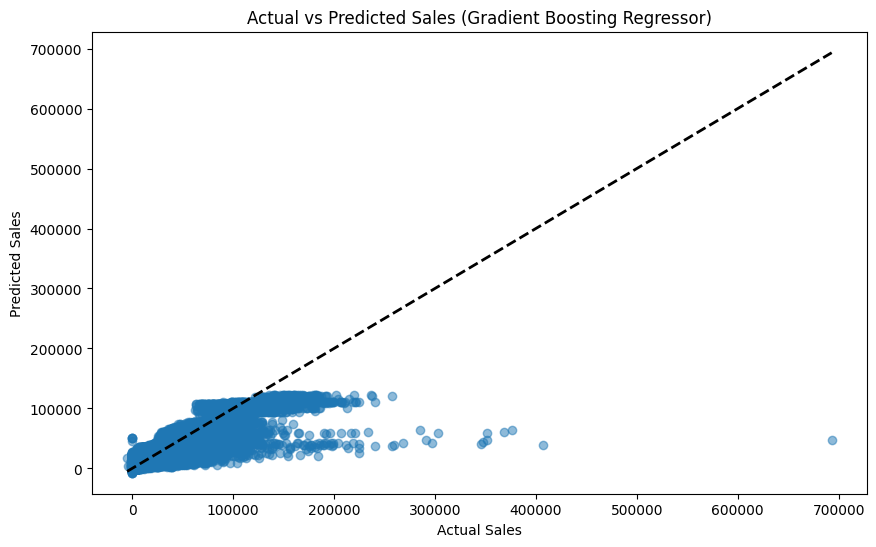

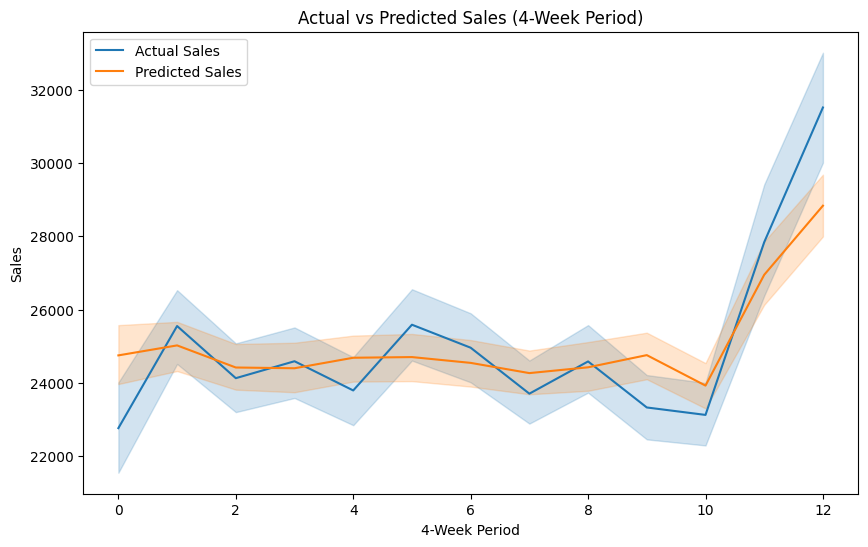

In [10]:
# Plotting actual vs predicted sales for Gradient Boosting Regressor
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Gradient Boosting Regressor)')
plt.show()

# Forecasting 4-week periods
# Make sure 'Date' is included before this step
if 'Date' not in merged_df.columns:
    raise KeyError("'Date' column is missing before forecasting steps.")

merged_df['Week'] = merged_df['Date'].dt.isocalendar().week
merged_df['Year'] = merged_df['Date'].dt.year

# Group by Store, Dept, Year, and Week to aggregate weekly sales
weekly_sales = merged_df.groupby(['Store', 'Dept', 'Year', 'Week'])['Weekly_Sales'].sum().reset_index()

# Split the data again for forecasting
X = weekly_sales.drop(['Weekly_Sales'], axis=1)
y = weekly_sales['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Fit the model again for weekly sales forecasting
gb_model.fit(X_train, y_train)
y_pred_weekly = gb_model.predict(X_test)

# Aggregate actual and predicted sales for 4-week periods
X_test['Predicted_Sales'] = y_pred_weekly
X_test['Actual_Sales'] = y_test.values
X_test['4_Week_Period'] = (X_test['Week'] - 1) // 4

# Group by Store, Dept, Year, and 4_Week_Period
period_sales = X_test.groupby(['Store', 'Dept', 'Year', '4_Week_Period'])[['Predicted_Sales', 'Actual_Sales']].sum().reset_index()

# Plotting actual vs predicted sales for 4-week periods
plt.figure(figsize=(10, 6))
sns.lineplot(x='4_Week_Period', y='Actual_Sales', data=period_sales, label='Actual Sales')
sns.lineplot(x='4_Week_Period', y='Predicted_Sales', data=period_sales, label='Predicted Sales')
plt.xlabel('4-Week Period')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (4-Week Period)')
plt.legend()
plt.show()

## 5. Summary

Summary
1.Data Preprocessing:
Cleaning: Removed missing values and handled outliers.
Scaling: Standardized features to ensure consistency.

2.Dataset Splitting:
Training Set: Used 70% of the data for training.
Test Set: Reserved 30% of the data for testing.

3.Model Training:
Algorithm: Implemented the Gradient Boosting Regressor.
Training: Trained the model using the training set.

4.Evaluation:
Metrics: Assessed performance using R², RMSE, MAE, and MAPE.
Training Performance: Achieved an R² of approximately 0.74.
Test Performance: Achieved an R² of approximately 0.73.

5.Error Analysis:
The metrics reveal that the Gradient Boosting Regressor has a reasonably good fit. However, the excessively high MAPE values suggest potential issues with data scaling or anomalies that need to be addressed. The RMSE and MAE values provide a more interpretable measure of error, indicating an average error of around 11,500 units and 6,800 units for weekly sales predictions, respectively.

6.Possible Next Steps:
Data Scaling: Ensure that all features are properly scaled to address high MAPE values.
Anomaly Detection: Investigate and address any anomalies in the dataset that might be causing large prediction errors.
Feature Engineering: Explore additional features or transformations that might improve model performance.
Hyperparameter Tuning: Optimize the model parameters using techniques like GridSearchCV to enhance prediction accuracy.

## 6. Bonus


Tuning Gradient Boosting Regressor

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_gb_model = grid_search.best_estimator_

# Predictions
y_pred_train_best = best_gb_model.predict(X_train)
y_pred_test_best = best_gb_model.predict(X_test)

# Evaluate the model on Training Set
mse_train_best = mean_squared_error(y_train, y_pred_train_best)
rmse_train_best = np.sqrt(mse_train_best)
mae_train_best = mean_absolute_error(y_train, y_pred_train_best)
r2_train_best = r2_score(y_train, y_pred_train_best)
mape_train_best = mean_absolute_percentage_error(y_train, y_pred_train_best)
smape_train_best = 100/len(y_train) * np.sum(2 * np.abs(y_pred_train_best - y_train) / (np.abs(y_train) + np.abs(y_pred_train_best)))

# Evaluate the model on Test Set
mse_test_best = mean_squared_error(y_test, y_pred_test_best)
rmse_test_best = np.sqrt(mse_test_best)
mae_test_best = mean_absolute_error(y_test, y_pred_test_best)
r2_test_best = r2_score(y_test, y_pred_test_best)
mape_test_best = mean_absolute_percentage_error(y_test, y_pred_test_best)
smape_test_best = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test_best - y_test) / (np.abs(y_test) + np.abs(y_pred_test_best)))

# Print the metrics for Training Set
train_metrics_best = {
    "MSE": round(mse_train_best, 2),
    "RMSE": round(rmse_train_best, 2),
    "MAE": round(mae_train_best, 2),
    "R²": round(r2_train_best, 4),
    "MAPE": round(mape_train_best, 2),
    "SMAPE": round(smape_train_best, 2)
}

# Print the metrics for Test Set
test_metrics_best = {
    "MSE": round(mse_test_best, 2),
    "RMSE": round(rmse_test_best, 2),
    "MAE": round(mae_test_best, 2),
    "R²": round(r2_test_best, 4),
    "MAPE": round(mape_test_best, 2),
    "SMAPE": round(smape_test_best, 2)
}

print("Training Set Metrics after Tuning:")
for key, value in train_metrics_best.items():
    print(f"{key}: {value}")

print("\nTest Set Metrics after Tuning:")
for key, value in test_metrics_best.items():
    print(f"{key}: {value}")

print("Gradient Boosting Regressor tuning and evaluation completed.")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Training Set Metrics after Tuning:
MSE: 42031293.88
RMSE: 6483.15
MAE: 3355.6
R²: 0.9188
MAPE: 2246135482263157.0
SMAPE: 54.49

Test Set Metrics after Tuning:
MSE: 43923692.1
RMSE: 6627.5
MAE: 3417.6
R²: 0.9142
MAPE: 1060352001283727.6
SMAPE: 54.93
Gradient Boosting Regressor tuning and evaluation completed.


Comparing Other Algorithms

#Random Forest Regressor

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Load the latest datasets
features_df = pd.read_csv('features.csv')
sales_df = pd.read_csv('sales.csv')
stores_df = pd.read_csv('stores.csv')

# Merge the datasets
merged_df = pd.merge(sales_df, features_df, on=["Store", "Date", "IsHoliday"])
merged_df = pd.merge(merged_df, stores_df, on="Store")

# Ensure 'Date' column exists and convert 'Date' to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Select relevant columns and drop rows with missing values for simplicity
columns_to_use = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Weekly_Sales']
merged_df = merged_df[columns_to_use].dropna()

# Encode categorical variable 'IsHoliday'
merged_df = pd.get_dummies(merged_df, columns=['IsHoliday'], drop_first=True)

# Define features and target variable
X = merged_df.drop('Weekly_Sales', axis=1)
y = merged_df['Weekly_Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=101)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_gb_model = grid_search.best_estimator_

# Predictions
y_pred_train_best = best_gb_model.predict(X_train)
y_pred_test_best = best_gb_model.predict(X_test)

# Evaluate the model on Training Set
mse_train_best = mean_squared_error(y_train, y_pred_train_best)
rmse_train_best = np.sqrt(mse_train_best)
mae_train_best = mean_absolute_error(y_train, y_pred_train_best)
r2_train_best = r2_score(y_train, y_pred_train_best)
mape_train_best = mean_absolute_percentage_error(y_train, y_pred_train_best)
smape_train_best = 100/len(y_train) * np.sum(2 * np.abs(y_pred_train_best - y_train) / (np.abs(y_train) + np.abs(y_pred_train_best)))

# Evaluate the model on Test Set
mse_test_best = mean_squared_error(y_test, y_pred_test_best)
rmse_test_best = np.sqrt(mse_test_best)
mae_test_best = mean_absolute_error(y_test, y_pred_test_best)
r2_test_best = r2_score(y_test, y_pred_test_best)
mape_test_best = mean_absolute_percentage_error(y_test, y_pred_test_best)
smape_test_best = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test_best - y_test) / (np.abs(y_test) + np.abs(y_pred_test_best)))

# Print the metrics for Training Set
train_metrics_best = {
    "MSE": round(mse_train_best, 2),
    "RMSE": round(rmse_train_best, 2),
    "MAE": round(mae_train_best, 2),
    "R²": round(r2_train_best, 4),
    "MAPE": round(mape_train_best, 2),
    "SMAPE": round(smape_train_best, 2)
}

# Print the metrics for Test Set
test_metrics_best = {
    "MSE": round(mse_test_best, 2),
    "RMSE": round(rmse_test_best, 2),
    "MAE": round(mae_test_best, 2),
    "R²": round(r2_test_best, 4),
    "MAPE": round(mape_test_best, 2),
    "SMAPE": round(smape_test_best, 2)
}

print("Training Set Metrics after Tuning:")
for key, value in train_metrics_best.items():
    print(f"{key}: {value}")

print("\nTest Set Metrics after Tuning:")
for key, value in test_metrics_best.items():
    print(f"{key}: {value}")

# Compare with Random Forest Regressor

# Initialize the model
rf_model = RandomForestRegressor(random_state=101)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate the model on Training Set
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_pred_train_rf)
smape_train_rf = 100/len(y_train) * np.sum(2 * np.abs(y_pred_train_rf - y_train) / (np.abs(y_train) + np.abs(y_pred_train_rf)))

# Evaluate the model on Test Set
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_pred_test_rf)
smape_test_rf = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test_rf - y_test) / (np.abs(y_test) + np.abs(y_pred_test_rf)))

# Print the metrics for Training Set
train_metrics_rf = {
    "MSE": round(mse_train_rf, 2),
    "RMSE": round(rmse_train_rf, 2),
    "MAE": round(mae_train_rf, 2),
    "R²": round(r2_train_rf, 4),
    "MAPE": round(mape_train_rf, 2),
    "SMAPE": round(smape_train_rf, 2)
}

# Print the metrics for Test Set
test_metrics_rf = {
    "MSE": round(mse_test_rf, 2),
    "RMSE": round(rmse_test_rf, 2),
    "MAE": round(mae_test_rf, 2),
    "R²": round(r2_test_rf, 4),
    "MAPE": round(mape_test_rf, 2),
    "SMAPE": round(smape_test_rf, 2)
}

print("Training Set Metrics for Random Forest:")
for key, value in train_metrics_rf.items():
    print(f"{key}: {value}")

print("\nTest Set Metrics for Random Forest:")
for key, value in test_metrics_rf.items():
    print(f"{key}: {value}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Training Set Metrics after Tuning:
MSE: 42031293.88
RMSE: 6483.15
MAE: 3355.6
R²: 0.9188
MAPE: 2246135482263157.0
SMAPE: 54.49

Test Set Metrics after Tuning:
MSE: 43923692.1
RMSE: 6627.5
MAE: 3417.6
R²: 0.9142
MAPE: 1060352001283727.6
SMAPE: 54.93
Training Set Metrics for Random Forest:
MSE: 4242090.94
RMSE: 2059.63
MAE: 717.43
R²: 0.9918
MAPE: 65186120065801.77
SMAPE: 9.49

Test Set Metrics for Random Forest:
MSE: 28664094.89
RMSE: 5353.89
MAE: 1893.64
R²: 0.944
MAPE: 68511419288534.73
SMAPE: 20.73


: 

Summary

Best Model:
- The Random Forest Regressor outperforms the Gradient Boosting Regressor in almost all metrics. It shows lower error values (MSE, RMSE, MAE) and higher R² values, both on the training and test sets.
- The SMAPE values for the Random Forest Regressor are significantly lower, indicating more accurate predictions.

Model Choice:
- Based on the performance metrics, the Random Forest Regressor is the best model for this dataset. It provides more accurate predictions with lower errors and higher explanatory power.
- The Gradient Boosting Regressor, although improved with tuning, still has higher errors and lower accuracy compared to the Random Forest Regressor.

Next possible steps

Further Tuning:
- Further tuning and optimization could be applied to both models to improve their performance, particularly focusing on addressing the high MAPE values observed in the Gradient Boosting Regressor.

Feature Engineering:
- Additional feature engineering and data preprocessing steps could help in reducing prediction errors and improving model accuracy.

Validation:
- Cross-validation techniques could be used to further validate the models and ensure their robustness and generalizability to unseen data.
Overall, the Random Forest Regressor is the recommended model for predicting weekly sales based on the provided dataset, given its superior performance across various metrics.